In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mlutils import decision_regions

np.set_printoptions(suppress=True)

# A simple classification

First we'll import some data. I'm using an extract from the Rock Property Catalog.

In [2]:
url = "https://raw.githubusercontent.com/scienxlab/datasets/refs/heads/main/rpc/3-lithologies.csv"
df = pd.read_csv(url).dropna()

df.head()

,RPC,Description,Lithology,Vp,Vs,Rho
0,101023,Gray Shale,shale,4953.66,2957.26,2.71
1,100978,Olentangy Shale,shale,3444.66,2318.00,2.68
2,100993,Brown Gas Shale,shale,3507.80,2218.53,2.56
3,101048,Shale 2 (Density is assumed constant),shale,2988.89,1633.33,2.60
4,100417,Tight gas shale,shale,3642.00,2221.00,2.46


We're going to predict lithology from `Vp` and `rho`.

In [3]:
X = df[['Vp', 'Rho']].values
y = df['Lithology'].values

X

array([[4953.66,    2.71],
       [3444.66,    2.68],
       [3507.8 ,    2.56],
       [2988.89,    2.6 ],
       [3642.  ,    2.46],
       [4987.07,    2.71],
       [4395.76,    2.51],
       [3819.02,    2.63],
       [3033.33,    2.6 ],
       [2402.74,    2.35],
       [2202.  ,    2.25],
       [3893.1 ,    2.56],
       [2509.12,    2.35],
       [3545.  ,    2.5 ],
       [3726.75,    2.6 ],
       [3750.62,    2.68],
       [3965.98,    2.63],
       [5258.46,    2.55],
       [3669.  ,    2.59],
       [4408.83,    2.6 ],
       [3048.  ,    2.42],
       [1490.71,    2.3 ],
       [5191.  ,    2.78],
       [4404.  ,    2.31],
       [3850.  ,    2.48],
       [3238.07,    2.68],
       [4722.78,    2.56],
       [3787.17,    2.51],
       [4484.63,    2.68],
       [5069.83,    2.56],
       [3044.44,    2.6 ],
       [4319.34,    2.68],
       [5320.42,    2.55],
       [2888.89,    2.6 ],
       [3921.54,    2.51],
       [3792.98,    2.56],
       [2290.84,    2.32],
 

Let's look at a plot:

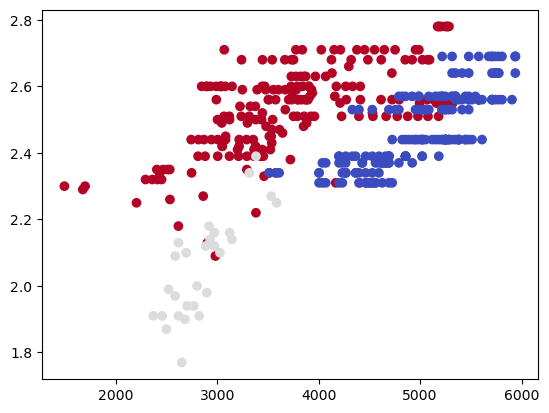

In [4]:
LITHOLOGIES = list(np.unique(y))
def lith_index(y):
    """Turns liths into numbers for plotting."""
    return [LITHOLOGIES.index(yi) for yi in y]

plt.scatter(*X.T, c=lith_index(y), cmap='coolwarm')

### ❓ What can we say about this dataset?

<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

- **There is a minority class (limestone).** (Can we get more limestone samples? Should we handle the missing data?)
- There's something strange about the density measurements. (Is there a problem?)
- There's quite a bit of overlap between classes.

It's a small dataset but not completely hopeless, we can probably learn something.

---

## A linear model: SVM

The **support vector machine** or SVM is a good model to start supervised classification with. It attempts to separate the classes with lines.

We will make an estimator called `svc` and a prediction called `y_pred`...

In [5]:
svc = SVC(kernel='linear')

svc.fit(X, y)

y_pred = svc.predict(X)

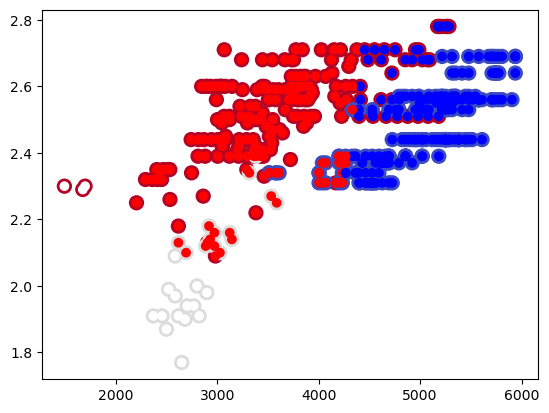

In [7]:
plt.scatter(*X.T, c=lith_index(y), s=100, cmap='coolwarm')
plt.scatter(*X.T, c=lith_index(y_pred), cmap='bwr')

And we'd like an accuracy score:

In [8]:
accuracy_score(y, y_pred)

0.8060747663551402

<h2>❓ What do we think of this?</h2>

- What is 'good performance'?
- What would make a good lower bound? 
- Is there an upper bound?
- Is 'accuracy' the best score?
- Is it fair to measure performance this way?

<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>


----

## Scoring

Scores matter in all machine learning tasks. It is very common to see people reporting only accuracy for classification tasks, or only R2 for regression tasks. It is almost never enough to only look at (or report) the 'obvious' score -- especially for multiclass problems like this one, and especially when there is class imbalance.

**This is one of the most important review papers in all of machine learning: [Raschka 2018](https://arxiv.org/abs/1811.12808). Read it and share it.**

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

    dolomite       0.80      0.90      0.84       200
   limestone       0.82      0.50      0.62        28
       shale       0.81      0.76      0.79       200

    accuracy                           0.81       428
   macro avg       0.81      0.72      0.75       428
weighted avg       0.81      0.81      0.80       428



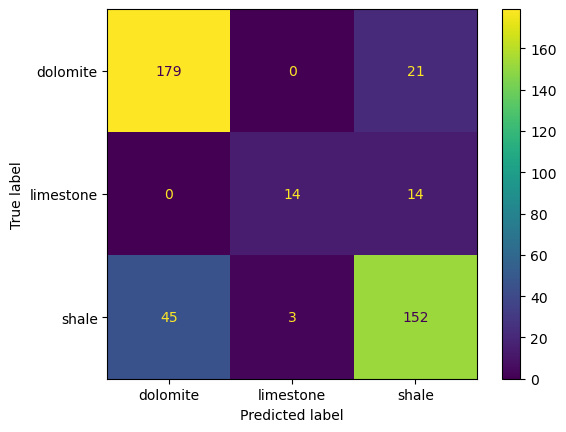

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, y_pred, labels=svc.classes_)
ConfusionMatrixDisplay(cm, display_labels=svc.classes_).plot()

## Validation

We should not train the model then check its accuracy only on that same training dataset. It's cheating.

We need to check against some rocks the model has not seen before. Let's hold out some validation data, or 'blind' data.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42)

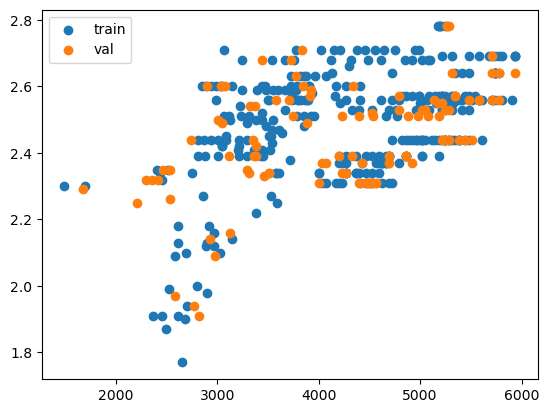

In [18]:
plt.scatter(*X_train.T, label='train')
plt.scatter(*X_val.T, label='val')
plt.legend()

In [19]:
sum(y_val == 'limestone')

7

### ❓ Can you think of some occasions when a random split might not be okay?

- Do we really want to roll the dice every time? We need the split to be reproducible.
- Certain proportions of classes? We may need to deal with class imbalance.
- Are the records IID: independent and identically distributed?

<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=13)

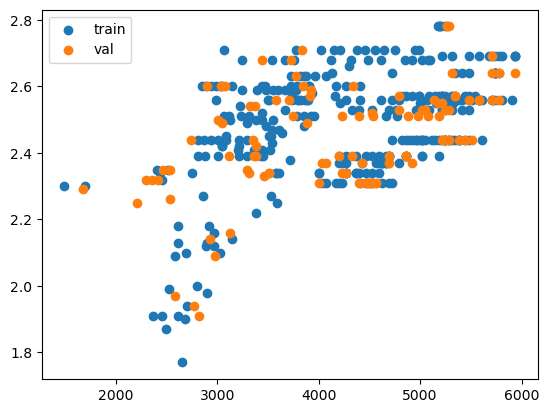

In [20]:
plt.scatter(*X_train.T, label='train')
plt.scatter(*X_val.T, label='val')
plt.legend()

Now we can train a model on only the training data and validate it properly on only the test data.

### ❓ Will the score go up or down?

<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

Because we're using less data to train, and because we're no longer checking the performance against data we trained on, the model probably gets a bit less predictive... but maybe we trust the prediction of future accuracy more.

In [ ]:
svc = SVC(kernel='linear')

svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)

print(classification_report(y_val, y_pred))

Do we care about the score against the training data?

Would we expect it to be lower or higher than the validation data?

<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

In [ ]:
y_pred_ = svc.predict(X_train)

print(classification_report(y_train, y_pred_))

**Does that seem okay?**

We'd normally expect the training score to be higher than the validation score. But we are relatively lucky with this validation set -- it's a bit more predictable than the training data itself.

Let's check how we're doing visually.

In [ ]:
plt.scatter(*X_val.T, c=lith_index(y_val), s=80, cmap='coolwarm')
plt.scatter(*X_val.T, c=lith_index(y_pred), cmap='bwr')

---

## A more complex model

Notice that the model is linear. This makes the possibly big assumption that the decision boundary is linear in the feature space.


### ❓ Will a non-linear model do better or worse?

<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

Let's try the default non-linear SVM, which uses a 'radial basis function' kernel.

In [ ]:
svc = SVC(kernel='rbf')

svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)

print(classification_report(y_val, y_pred))

In [ ]:
plt.scatter(*X_val.T, c=lith_index(y_val), s=80, cmap='coolwarm')
plt.scatter(*X_val.T, c=lith_index(y_pred), cmap='bwr')

### ❓ The model is worse. Why?

<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

In [ ]:
plt.scatter(*X.T, c=lith_index(y), cmap='coolwarm')
# plt.axis('equal')

### ❓ What can we do about it?

<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

---

## Standardization

We gave the model our raw data. We get away with it with the linear model, but any algorithms that depend on distance — either in the learning algorithm, or the cost function, or in regularization — would prefer to have standardized data. That way, they work in 'Z-score' space. (When you plot with `matplotlib` it's doing a min/max scaling on both axes so that the points look reasonable. It's a similar idea.)

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
plt.scatter(*X_train.T, label='train')
plt.scatter(*X_val.T, label='val')
plt.legend()
plt.axis('equal')  # <-- So we can see the data space as sklearn 'sees' it.
plt.show()

Both models will be better.

In [ ]:
svc = SVC(kernel='linear')

svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)

print(classification_report(y_val, y_pred))

In [ ]:
svc = SVC(kernel='rbf')

svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)

print(classification_report(y_val, y_pred))

Solving one problem gives us a new one. Now we have a new pitfall: it is essential to scale the data now before inference -- although the model will happily make (terrible) predictions on unscaled data.

In [ ]:
svc.predict([[2509, 2.35]])

This is known as an "out of distribution" or OOD error, and it's a classic pitfall in machine learning.

The best way to avoid this error is to use `sklearn.pipeline.Pipeline` objects instead of using estimators directly. You can put the scaler and the estimator in a pipeline like so:

    pipe = sklearn.pipeline.make_pipeline(scaler, svc)

The you can fit and predict with `pipe` like you can with a normal estimator.

The pipeline will take care of only using `fit` on the scaler when you are fitting the model, and only using `transform` when you do the `predict` step.

---

## Untuned model

We didn't try to adjust hyperparameters to get a better fit. Turns out, if you do this, the model does better with a different value for `C`:

In [ ]:
vals = []
for C in (Cs := np.logspace(-3, 4, 15)):
    svc = SVC(C=C).fit(X_train, y_train)
    vals.append(svc.score(X_val, y_val))
    
plt.plot(Cs, vals, 'o-')
plt.axvline(1, c='r')
plt.xscale('log')

Now we have to make a decision about what we think is more reasonable.

After that, there are plenty more gotchas:

- As we try more things, we need to start using a `test` dataset.
- We have assumed that the labels are correct and the data is accurate.
- A few hundred records is not much data; we should be careful about where we apply this model.
- We have only tried one model type, and have not tuned all of its hyperparameters.
- As we add more features, we have to remember the curse of dimensionality.
- This evaluation process is for tuning the model, not training the model. So don't forget to train the final model on all the data!

---

&copy; 2024 Matt Hall, licensed CC BY